# Compare observed monthly sea ice extent with meridional wind, using scatterplots and contour plots

#### filepaths, dates etc

In [1]:
latmin = -65. ; latmax = -55. # latitude range over which to average wind


#sea ice extent
isrc = 'NSIDC'
diri = '/g/data/gv90/wrh581/'+isrc+'/'
iNam = 'SIA'


# merid wind
asrc  = 'era5'
aNam = 'v10'
dira = '/g/data/rt52/'+asrc+'/single-levels/monthly-averaged/10v/'

#output filepath


#### sector definitions

In [2]:
sector = {
        'Ross' : {'minlon' : 175., 'maxlon' : 220.},
        'Amundsen' : {'minlon' : 220., 'maxlon' : 277.},
        'Bellingshausen' : {'minlon' : 277.,  'maxlon' : 295.},
        'Weddell' : {'minlon' : 327., 'maxlon' : 10.},
        'King Haakon' : {'minlon' : 10., 'maxlon' : 70.}
    }

In [3]:
import matplotlib.pyplot as plt
import matplotlib
import glob
import numpy as np
import xarray as xr
import cf_xarray as cf
import calendar
import scipy.stats as stats
import pandas as pd
import datetime

%matplotlib inline

### read SIA

In [22]:

fili = glob.glob(diri+'NSIDC_SH_icearea_v0?r00_*.nc')
SIA = xr.open_mfdataset(fili, parallel = True)

#add datetime array
SIA['time'] = [datetime.datetime.strptime(str(date), "%Y%m") for date in SIA.time.values]
SIA = (SIA['SIA'] * 1.e-6).compute() 



### read wind

In [14]:

#string list of years for same range as sea ice data      
yrst = SIA.time[0].dt.year.values ; yren = SIA.time.max().dt.year.values
yrstring = [str(yr) for yr in  np.arange(yrst,yren+1) ]

cmd = 'ls '+dira+'{'+','.join(yrstring)+'}/*.nc  2>/dev/null'
fila = !$cmd

adata = xr.open_mfdataset(fila, parallel = True)


#get mean
adata = adata.cf.sel(latitude = slice(latmax, latmin))
wgts  = np.cos(np.deg2rad(adata.cf['latitude']))
wind = adata[aNam].weighted(wgts).mean(adata.cf['latitude'].name).compute()

#change lon coord to 0-360 (if necessary)
pivot = wind.cf['longitude'].min().values
if (pivot < 0.):

    xtmp = wind.cf['longitude'].values
    xtmp = np.where(xtmp < 0., xtmp+360., xtmp)
    
wind[wind.cf['longitude'].name] = xtmp


### calculate sector anomalies

In [23]:
sector_mean = xr.Dataset(
    data_vars = {'SIA' : (['sector','month','year'], np.full( (len(sector),12,(yren-yrst+1)), np.nan)),
                 'wind' : (['sector','month','year'],np.full( (len(sector),12,(yren-yrst+1)), np.nan))},
    coords = {'sector' : list(sector.keys()),
              'month' : np.arange(1,13), 
              'year' : np.arange(yrst, yren+1)}
            )

In [24]:
def lon_selection(var, xmin, xmax):
    if xmin < xmax:
        var_sel = var.where((var.cf['longitude'] <= xmax) & (var.cf['longitude'] > xmin))
    else:
        #this covers case where sector crosses the longitude pivot point
        var_sel = var.where((var.cf['longitude'] <= xmax) | (var.cf['longitude'] > xmin))
    return var_sel

def time_reord(var):
    var_reord = var.assign_coords(year=var['time.year'],month=var['time.month'])
    var_reord = var_reord.groupby(['year', 'month']).mean(dim='time')
    return var_reord    

In [32]:

for sname in sector:
    xmin = sector[sname]['minlon']
    xmax = sector[sname]['maxlon']

    ## wind
    
    tmp = lon_selection(wind, xmin, xmax)#.sel(time = sector_mean.time)
    tmp = tmp.mean(tmp.cf['longitude'].name)
    sector_mean['wind'].loc[{'sector' : sname}] = time_reord(tmp)
    
    #SIE
    tmp = lon_selection(SIA, xmin, xmax)
    tmp = tmp.sum(tmp.cf['longitude'].name)
    sector_mean['SIA'].loc[{'sector' : sname}] =  time_reord(tmp)



sector_mean = sector_mean - sector_mean.mean('year').compute()

#mask instrument dropouts from sea ice
sector_mean['SIA'].loc[{'year' :1987, 'month' :12}] = np.nan
sector_mean['SIA'].loc[{'year' :1988, 'month' :1}] = np.nan



### Time plot (by sector) of wind vs sea ice

In [26]:
def wind_ice_tplot(plot_sector, plot_month, ax):
    selcond = {'sector' : plot_sector, 'month' : plot_month}

    sector_mean['SIA'].sel(**selcond).plot(ax=ax, c='k')
    plt.axhline(0.,c='k')
    plt.ylim([-1.,1.])
    ax.set_ylabel('SIA anom (million km$^2$)', fontsize = 15, color='k')
    plt.title('')

    ax2 = ax.twinx()
    sector_mean['wind'].sel(**selcond).plot(ax=ax2, c='r')
    plt.ylim([-3.,3.])
    plt.title('')
    
    ax2.set_ylabel('v wind anom (ms$^-1$)', fontsize = 15, color='r')
    ax2.tick_params(axis='y', labelcolor='r')

    ax.set_title(calendar.month_name[plot_month],fontsize = 20, loc = 'left')


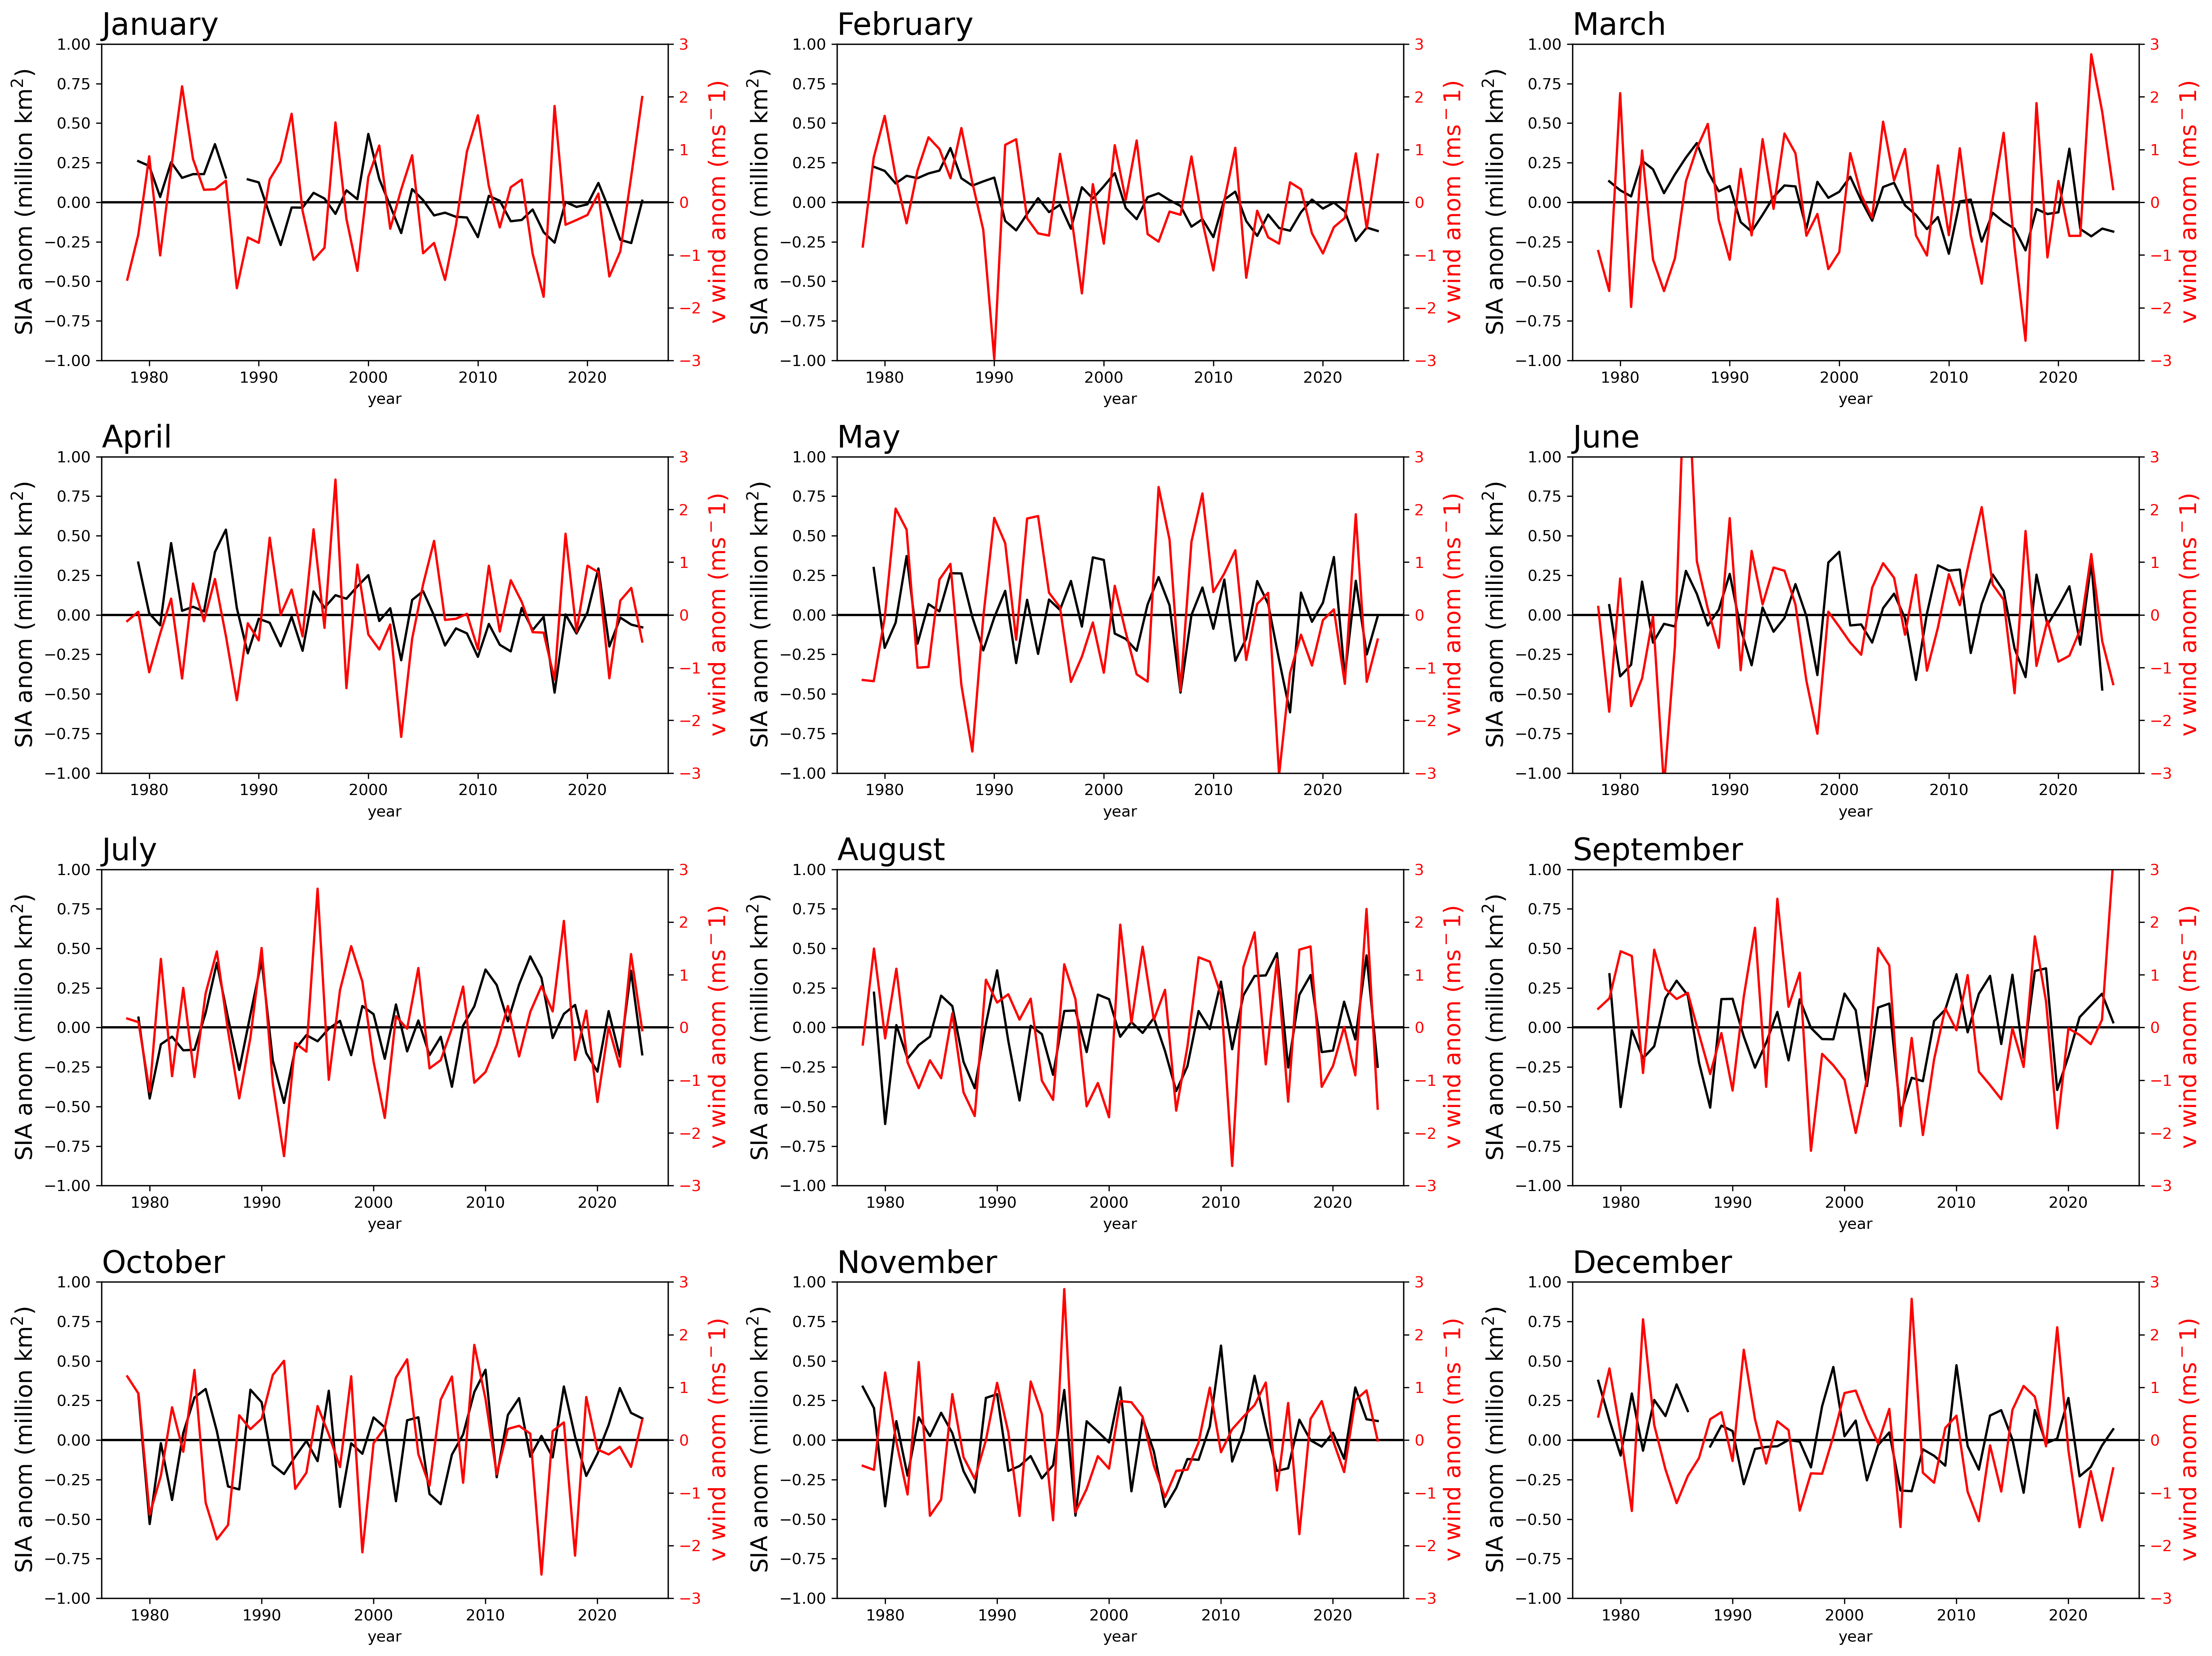

In [33]:
plt.figure(figsize=(20,15), dpi=300)
plsec =   'Amundsen'

for m in range(1,13):
        ax = plt.subplot(4, 3, m)
        wind_ice_tplot(plsec,m, ax)

plt.tight_layout()
plt.show()

### Scatter plot for selected month/longitude range

In [11]:

def wind_ice_scatter(plot_sector, plot_month, refyears):

    selcond = {'sector' : plot_sector, 'month' : plot_month}

    x    = sector_mean['wind'].sel(**selcond)
    y    = sector_mean['SIA'].sel(**selcond)
    mask = np.isfinite(x) & np.isfinite(y)
    x    = x[mask] ; y = y[mask]

    plt.scatter(x.values,y.values, s = 15, c='darkgray')

    #plot selected reference years in red
    selcond.update({'year' : refyears})
    plt.scatter(sector_mean['wind'].sel(**selcond).values,
                      sector_mean['SIA'].sel(**selcond).values,
                s =60, c='red')

    #regression line
    regfit = stats.linregress(x.values, y.values)
    plt.plot(x, x*regfit.slope + regfit.intercept, c = 'k', linewidth = 1.5,)

    
    plt.axhline(0.,c='k', linestyle='--', linewidth=1.)
    plt.axvline(0.,c='k', linestyle='--',linewidth=1.)
    plt.ylabel('SIA (million km$^2$)', fontsize = 15)
    plt.xlabel('v wind (ms$^-1$)', fontsize = 15)
    plt.title(calendar.month_name[plot_month],fontsize = 20, loc = 'left')

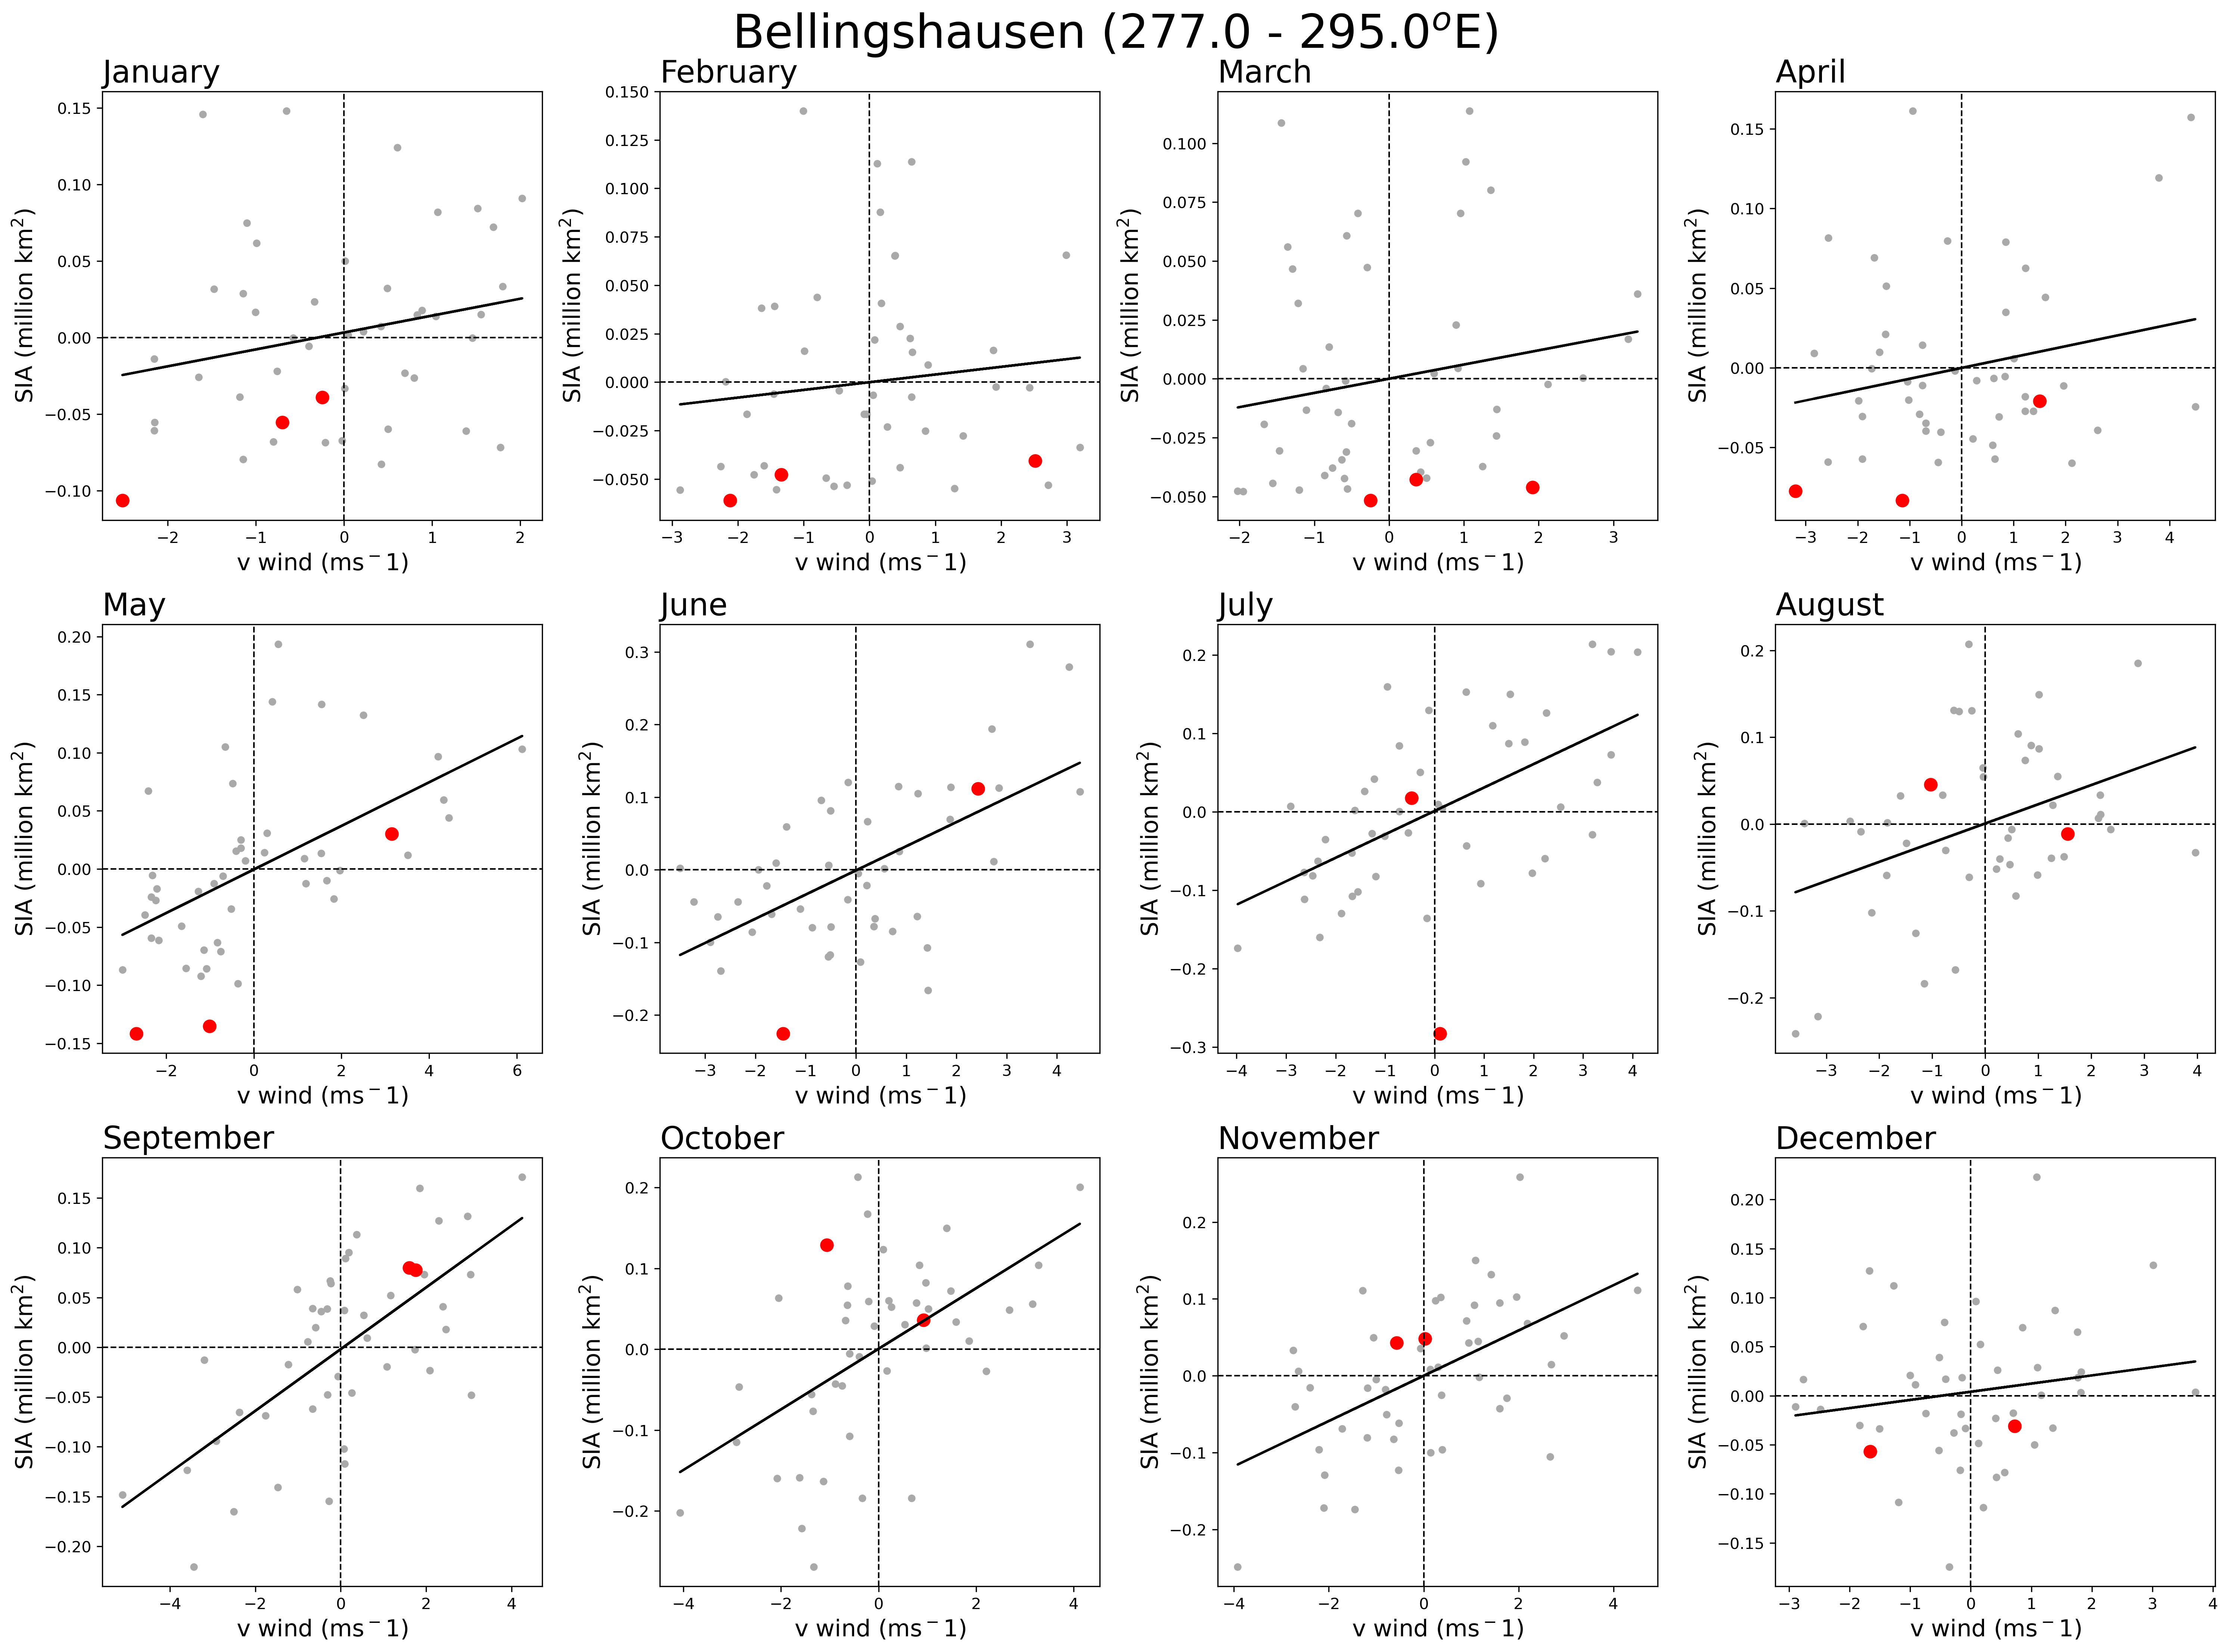

In [36]:

plt.figure(figsize=(20,15), dpi=300)
plsec =   'Bellingshausen'

for m in range(1,13):
        ax = plt.subplot(3, 4, m)
        wind_ice_scatter(plsec,m,[2023, 2024,2025])

pltitle =plsec+' ('+str(sector[plsec]['minlon'])+' - '+str(sector[plsec]['maxlon'])+'$^o$E)'
plt.suptitle(pltitle,fontsize = 30)
plt.tight_layout()
plt.show()
